In [ ]:
!git clone https://github.com/Mayankjha1535/Alzheimer-s-Disease-Prediction-using-NLP

fatal: destination path 'Alzheimer-s-Disease-Prediction-using-NLP' already exists and is not an empty directory.


In [ ]:
import gensim
import pandas as pd
import keras
import pickle
import numpy as np

In [ ]:
filename = '/content/Alzheimer-s-Disease-Prediction-using-NLP/preprocessed_data.pkl'

In [ ]:
data=pickle.load(open(filename,'rb')) ###open preprocessed data

In [ ]:
len(data)

3243

In [ ]:
Y= data.iloc[:,1].values
Y

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
###Manually resolve the tabbed data errors

index = [791,  792,  793,  830,  831,  832,  833,  839,  844, 846, 852,  853,
         855,  858,  860,  876,  882,  890,  892,  904,  909,  912,  936,
         938,  943,  945,  957,  964,  965,  967,  969,  972,  975,  976,
        1000, 1007, 1013, 1018, 1297] 
for i in index:
    Y[i] = 0  ###replace value of selected indices of AD column with 0

idx = [1072, 1101, 1184, 1244]
for i in idx:
    Y[i] = 1  ###replace value of selected indices of AD column with 1
Y = Y.astype(int)

In [ ]:
X = data['Transcript'].tolist()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0) ##split the data in training and testing

In [ ]:
print(len(X_train)) ###length of training, testing data
print(len(X_test))
print(len(Y_train))
print(len(Y_test))

2594
649
2594
649


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
def create_tokens(lines):
    tokens = Tokenizer()        ###function to create tokens
    tokens.fit_on_texts(lines)
    return tokens

In [ ]:
train_tokenizer = create_tokens(X_train)

In [ ]:
def encode_sentences(tokens,length,lines):   ###function to pad the data to maximum phrase length
    X=tokens.texts_to_sequences(lines)
    X=pad_sequences(X,length,padding='post')
    return X    

In [ ]:
X_train = encode_sentences(train_tokenizer,100, X_train)
X_test = encode_sentences(train_tokenizer,100, X_test)

In [ ]:
print(X_train.shape)   ###check for dimensions
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2594, 100)
(649, 100)
(2594,)
(649,)


In [ ]:
vocab_len= len(train_tokenizer.word_index ) + 1 
vocab_len   ###vocab length

847

# Attention MODEL - Case 1: Training the model using randomly initialized embedding

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM, Bidirectional, Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dense 
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
from keras.layers import Layer
import keras.backend as K
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()


In [ ]:
seq_input = keras.Input(shape=(100,))
e = Embedding(vocab_len, 100, input_length= 100)(seq_input)
conv1 = Conv1D(filters=128,kernel_size=5,activation='relu',strides= 1, kernel_initializer='he_uniform')(e)
pool = MaxPooling1D(pool_size=2)(conv1)
dropout= Dropout(0.5)(pool)
lstm1 = Bidirectional(LSTM(10, return_sequences=True))(dropout)
att=attention()(lstm1)
dense1 = Dense(units = 20, activation='relu', kernel_initializer='he_uniform')(att)
output= Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform')(dense1)
model=keras.Model(seq_input,output)


In [ ]:
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
attention_history=model.fit(X_train, Y_train, epochs = 25, batch_size = 64, verbose = 1, validation_split = 0.1)

Epoch 1/25
37/37 [==============================] - 5s 49ms/step - loss: 0.6946 - accuracy: 0.4979 - val_loss: 0.6916 - val_accuracy: 0.5577
Epoch 2/25
37/37 [==============================] - 0s 10ms/step - loss: 0.6921 - accuracy: 0.5243 - val_loss: 0.6892 - val_accuracy: 0.5615
Epoch 3/25
37/37 [==============================] - 0s 11ms/step - loss: 0.6836 - accuracy: 0.5936 - val_loss: 0.6484 - val_accuracy: 0.6769
Epoch 4/25
37/37 [==============================] - 0s 11ms/step - loss: 0.5907 - accuracy: 0.7197 - val_loss: 0.5740 - val_accuracy: 0.7115
Epoch 5/25
37/37 [==============================] - 0s 11ms/step - loss: 0.4891 - accuracy: 0.7883 - val_loss: 0.6278 - val_accuracy: 0.6731
Epoch 6/25
37/37 [==============================] - 0s 11ms/step - loss: 0.4403 - accuracy: 0.8116 - val_loss: 0.5764 - val_accuracy: 0.7192
Epoch 7/25
37/37 [==============================] - 0s 11ms/step - loss: 0.3749 - accuracy: 0.8373 - val_loss: 0.5395 - val_accuracy: 0.7654
Epoch 8/25
37

In [ ]:
score = model.evaluate(X_test,Y_test,verbose = 1)
score[1]

21/21 [==============================] - 0s 4ms/step - loss: 0.5247 - accuracy: 0.8459


0.8459168076515198

In [ ]:
Y_pred = model.predict(X_test)
Y_pred = (Y_pred >0.5)

In [ ]:
confusion = confusion_matrix(Y_test,Y_pred)        ###Model evaluation
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
F1 = f1_score(Y_test,Y_pred)
specificity = (confusion[0][0]/(confusion[0][0]+confusion[0][1]))
print('confusion matrix {}'.format(confusion))
print('precision is {}'.format(precision))
print('recall is  {}'.format(recall))
print('F1 score {}'.format(F1))
print('specificity is {}'.format(specificity))

confusion matrix [[303  39]
 [ 61 246]]
precision is 0.8631578947368421
recall is  0.8013029315960912
F1 score 0.8310810810810811
specificity is 0.8859649122807017


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42069)
preds = []
fold = 0
aucs = 0
for train_idx, val_idx in kf.split(X_train):
    x_train_f = X_train[train_idx]
    y_train_f = Y_train[train_idx]
    x_val_f = X_train[val_idx]
    y_val_f = Y_train[val_idx]
    model.fit(x_train_f, y_train_f,
              batch_size=256,
              epochs=10,
              verbose = 0,
              validation_data=(x_val_f, y_val_f))
    # Get accuracy of model on validation data. It's not AUC but it's something at least!
    preds_val = model.predict([x_val_f], batch_size=512)
    preds.append(model.predict(X_test))
    fold+=1
    fpr, tpr, thresholds = roc_curve(y_val_f, preds_val, pos_label=1)
    aucs += auc(fpr,tpr)
    print('Fold {}, AUC = {}'.format(fold,auc(fpr, tpr)))
print("Cross Validation AUC = {}".format(aucs/10))

Fold 1, AUC = 0.9884883996212122
Fold 2, AUC = 0.9750236742424243
Fold 3, AUC = 0.9934518518518519
Fold 4, AUC = 0.9828467804268982
Fold 5, AUC = 0.9915666266506603
Fold 6, AUC = 0.9852817745803357
Fold 7, AUC = 0.9920424403183024
Fold 8, AUC = 0.99519804342639
Fold 9, AUC = 0.9898577612863327
Fold 10, AUC = 0.9895572263993317
Cross Validation AUC = 0.9883314578803738


In [ ]:
def model_attention_create(optimizer = 'Adam',
                 dropout_rate = 0.2, nb_filters = 256, kernel_size = 5,pool_size=2,units = 128,neurons = 20):
    
    seq_input = keras.Input(shape=(100,))
    e = Embedding(vocab_len, 100, input_length= 100)(seq_input)
    conv1 = Conv1D(nb_filters,kernel_size,activation='relu',strides= 1, kernel_initializer='he_uniform')(e)
    pool = MaxPooling1D(pool_size)(conv1)
    dropout= Dropout(0.5)(pool)
    lstm1 = Bidirectional(LSTM(10, return_sequences=True))(dropout)
    att=attention()(lstm1)
    dense1 = Dense(units = neurons, activation='relu', kernel_initializer='he_uniform')(att)
    output= Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform')(dense1)
    model=keras.Model(seq_input,output) 
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])    
    return model

In [ ]:
param_grid = {
    'units': [10,20,64,128]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] units=10 ........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
65/65 - 4s - loss: 0.6936 - accuracy: 0.5118
Epoch 2/10
65/65 - 1s - loss: 0.6713 - accuracy: 0.5764
Epoch 3/10
65/65 - 1s - loss: 0.5681 - accuracy: 0.7210
Epoch 4/10
65/65 - 1s - loss: 0.4592 - accuracy: 0.8058
Epoch 5/10
65/65 - 1s - loss: 0.3904 - accuracy: 0.8467
Epoch 6/10
65/65 - 1s - loss: 0.3493 - accuracy: 0.8641
Epoch 7/10
65/65 - 1s - loss: 0.3070 - accuracy: 0.8848
Epoch 8/10
65/65 - 1s - loss: 0.2798 - accuracy: 0.8949
Epoch 9/10
65/65 - 1s - loss: 0.2577 - accuracy: 0.9099
Epoch 10/10
65/65 - 1s - loss: 0.2368 - accuracy: 0.9166
17/17 - 1s - loss: 0.5270 - accuracy: 0.8073
[CV] ......................................... units=10, total=  10.1s
[CV] units=10 ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s


Epoch 1/10
65/65 - 4s - loss: 0.6914 - accuracy: 0.5258
Epoch 2/10
65/65 - 1s - loss: 0.6807 - accuracy: 0.5817
Epoch 3/10
65/65 - 1s - loss: 0.5726 - accuracy: 0.7147
Epoch 4/10
65/65 - 1s - loss: 0.4741 - accuracy: 0.8005
Epoch 5/10
65/65 - 1s - loss: 0.3959 - accuracy: 0.8458
Epoch 6/10
65/65 - 1s - loss: 0.3354 - accuracy: 0.8689
Epoch 7/10
65/65 - 1s - loss: 0.2789 - accuracy: 0.8935
Epoch 8/10
65/65 - 1s - loss: 0.2501 - accuracy: 0.9084
Epoch 9/10
65/65 - 1s - loss: 0.2734 - accuracy: 0.8978
Epoch 10/10
65/65 - 1s - loss: 0.2246 - accuracy: 0.9224
17/17 - 1s - loss: 0.4929 - accuracy: 0.8131
[CV] ......................................... units=10, total=  10.6s
[CV] units=10 ........................................................
Epoch 1/10
65/65 - 4s - loss: 0.6946 - accuracy: 0.5210
Epoch 2/10
65/65 - 1s - loss: 0.6703 - accuracy: 0.5918
Epoch 3/10
65/65 - 1s - loss: 0.5707 - accuracy: 0.7219
Epoch 4/10
65/65 - 1s - loss: 0.4770 - accuracy: 0.7889
Epoch 5/10
65/65 - 1s - loss

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.5min finished


Epoch 1/10
82/82 - 4s - loss: 0.6938 - accuracy: 0.5046
Epoch 2/10
82/82 - 1s - loss: 0.6739 - accuracy: 0.5702
Epoch 3/10
82/82 - 1s - loss: 0.5750 - accuracy: 0.7151
Epoch 4/10
82/82 - 1s - loss: 0.4835 - accuracy: 0.7868
Epoch 5/10
82/82 - 1s - loss: 0.3833 - accuracy: 0.8450
Epoch 6/10
82/82 - 1s - loss: 0.3192 - accuracy: 0.8824
Epoch 7/10
82/82 - 1s - loss: 0.2898 - accuracy: 0.8913
Epoch 8/10
82/82 - 1s - loss: 0.2576 - accuracy: 0.9044
Epoch 9/10
82/82 - 1s - loss: 0.2380 - accuracy: 0.9106
Epoch 10/10
82/82 - 1s - loss: 0.2293 - accuracy: 0.9144
Best accuracy:  0.7979958415031433
Best parameters:  {'units': 64}


In [ ]:
param_grid = {
    'nb_filters': [128,256],
    'kernel_size':[3,5],
    'pool_size':[2,4]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] kernel_size=3, nb_filters=128, pool_size=2 ......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
65/65 - 4s - loss: 0.6939 - accuracy: 0.5055
Epoch 2/10
65/65 - 1s - loss: 0.6806 - accuracy: 0.5812
Epoch 3/10
65/65 - 1s - loss: 0.5677 - accuracy: 0.7157
Epoch 4/10
65/65 - 1s - loss: 0.4777 - accuracy: 0.8000
Epoch 5/10
65/65 - 1s - loss: 0.4221 - accuracy: 0.8222
Epoch 6/10
65/65 - 1s - loss: 0.3567 - accuracy: 0.8617
Epoch 7/10
65/65 - 1s - loss: 0.3329 - accuracy: 0.8728
Epoch 8/10
65/65 - 1s - loss: 0.3088 - accuracy: 0.8810
Epoch 9/10
65/65 - 1s - loss: 0.2885 - accuracy: 0.8920
Epoch 10/10
65/65 - 1s - loss: 0.2772 - accuracy: 0.8925
17/17 - 1s - loss: 0.5452 - accuracy: 0.7977
[CV] ....... kernel_size=3, nb_filters=128, pool_size=2, total=  10.0s
[CV] kernel_size=3, nb_filters=128, pool_size=2 ......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s


Epoch 1/10
65/65 - 4s - loss: 0.6934 - accuracy: 0.5267
Epoch 2/10
65/65 - 1s - loss: 0.6783 - accuracy: 0.5961
Epoch 3/10
65/65 - 1s - loss: 0.5807 - accuracy: 0.7219
Epoch 4/10
65/65 - 1s - loss: 0.4842 - accuracy: 0.7986
Epoch 5/10
65/65 - 1s - loss: 0.4133 - accuracy: 0.8361
Epoch 6/10
65/65 - 1s - loss: 0.3773 - accuracy: 0.8492
Epoch 7/10
65/65 - 1s - loss: 0.3367 - accuracy: 0.8737
Epoch 8/10
65/65 - 1s - loss: 0.3018 - accuracy: 0.8896
Epoch 9/10
65/65 - 1s - loss: 0.2886 - accuracy: 0.8930
Epoch 10/10
65/65 - 1s - loss: 0.2859 - accuracy: 0.8949
17/17 - 1s - loss: 0.5017 - accuracy: 0.8015
[CV] ....... kernel_size=3, nb_filters=128, pool_size=2, total=  10.5s
[CV] kernel_size=3, nb_filters=128, pool_size=2 ......................
Epoch 1/10
65/65 - 4s - loss: 0.6935 - accuracy: 0.5089
Epoch 2/10
65/65 - 1s - loss: 0.6879 - accuracy: 0.5427
Epoch 3/10
65/65 - 1s - loss: 0.6038 - accuracy: 0.6858
Epoch 4/10
65/65 - 1s - loss: 0.4856 - accuracy: 0.7822
Epoch 5/10
65/65 - 1s - loss

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  6.7min finished


Epoch 1/10
82/82 - 5s - loss: 0.6925 - accuracy: 0.5177
Epoch 2/10
82/82 - 1s - loss: 0.6497 - accuracy: 0.6210
Epoch 3/10
82/82 - 1s - loss: 0.5165 - accuracy: 0.7664
Epoch 4/10
82/82 - 1s - loss: 0.4215 - accuracy: 0.8288
Epoch 5/10
82/82 - 1s - loss: 0.3526 - accuracy: 0.8531
Epoch 6/10
82/82 - 1s - loss: 0.2885 - accuracy: 0.8874
Epoch 7/10
82/82 - 1s - loss: 0.2644 - accuracy: 0.8978
Epoch 8/10
82/82 - 1s - loss: 0.2354 - accuracy: 0.9082
Epoch 9/10
82/82 - 1s - loss: 0.2225 - accuracy: 0.9121
Epoch 10/10
82/82 - 1s - loss: 0.2102 - accuracy: 0.9190
Best accuracy:  0.8184227108955383
Best parameters:  {'kernel_size': 3, 'nb_filters': 256, 'pool_size': 4}


In [ ]:
param_grid = {
    'neurons':[10,20,64,128]
}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] neurons=10 ......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
65/65 - 4s - loss: 0.6945 - accuracy: 0.5031
Epoch 2/10
65/65 - 1s - loss: 0.6735 - accuracy: 0.5880
Epoch 3/10
65/65 - 1s - loss: 0.5750 - accuracy: 0.7210
Epoch 4/10
65/65 - 1s - loss: 0.5011 - accuracy: 0.7696
Epoch 5/10
65/65 - 1s - loss: 0.4410 - accuracy: 0.8116
Epoch 6/10
65/65 - 1s - loss: 0.3793 - accuracy: 0.8506
Epoch 7/10
65/65 - 1s - loss: 0.3439 - accuracy: 0.8675
Epoch 8/10
65/65 - 1s - loss: 0.3014 - accuracy: 0.8810
Epoch 9/10
65/65 - 1s - loss: 0.2804 - accuracy: 0.8954
Epoch 10/10
65/65 - 1s - loss: 0.2621 - accuracy: 0.8998
17/17 - 1s - loss: 0.4916 - accuracy: 0.8073
[CV] ....................................... neurons=10, total=  10.1s
[CV] neurons=10 ......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s remaining:    0.0s


Epoch 1/10
65/65 - 4s - loss: 0.6935 - accuracy: 0.5176
Epoch 2/10
65/65 - 1s - loss: 0.6906 - accuracy: 0.5195
Epoch 3/10
65/65 - 1s - loss: 0.6335 - accuracy: 0.6622
Epoch 4/10
65/65 - 1s - loss: 0.5357 - accuracy: 0.7561
Epoch 5/10
65/65 - 1s - loss: 0.4921 - accuracy: 0.7942
Epoch 6/10
65/65 - 1s - loss: 0.4299 - accuracy: 0.8304
Epoch 7/10
65/65 - 1s - loss: 0.4107 - accuracy: 0.8347
Epoch 8/10
65/65 - 1s - loss: 0.3670 - accuracy: 0.8622
Epoch 9/10
65/65 - 1s - loss: 0.3494 - accuracy: 0.8699
Epoch 10/10
65/65 - 1s - loss: 0.3128 - accuracy: 0.8896
17/17 - 1s - loss: 0.5261 - accuracy: 0.7938
[CV] ....................................... neurons=10, total=  10.7s
[CV] neurons=10 ......................................................
Epoch 1/10
65/65 - 4s - loss: 0.6948 - accuracy: 0.5157
Epoch 2/10
65/65 - 1s - loss: 0.6891 - accuracy: 0.5354
Epoch 3/10
65/65 - 1s - loss: 0.6196 - accuracy: 0.6795
Epoch 4/10
65/65 - 1s - loss: 0.5257 - accuracy: 0.7629
Epoch 5/10
65/65 - 1s - loss

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.5min finished


Epoch 1/10
82/82 - 4s - loss: 0.6932 - accuracy: 0.5135
Epoch 2/10
82/82 - 1s - loss: 0.6453 - accuracy: 0.6315
Epoch 3/10
82/82 - 1s - loss: 0.5361 - accuracy: 0.7483
Epoch 4/10
82/82 - 1s - loss: 0.4364 - accuracy: 0.8204
Epoch 5/10
82/82 - 1s - loss: 0.3515 - accuracy: 0.8577
Epoch 6/10
82/82 - 1s - loss: 0.3051 - accuracy: 0.8851
Epoch 7/10
82/82 - 1s - loss: 0.2625 - accuracy: 0.8994
Epoch 8/10
82/82 - 1s - loss: 0.2315 - accuracy: 0.9144
Epoch 9/10
82/82 - 1s - loss: 0.2162 - accuracy: 0.9190
Epoch 10/10
82/82 - 1s - loss: 0.1972 - accuracy: 0.9233
Best accuracy:  0.805701494216919
Best parameters:  {'neurons': 128}


In [ ]:
param_grid = {
    'dropout_rate':[0.1,0.2,0.3,0.4,0.5]
}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] dropout_rate=0.1 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
65/65 - 4s - loss: 0.6942 - accuracy: 0.4834
Epoch 2/10
65/65 - 1s - loss: 0.6929 - accuracy: 0.5123
Epoch 3/10
65/65 - 1s - loss: 0.6735 - accuracy: 0.5894
Epoch 4/10
65/65 - 1s - loss: 0.5542 - accuracy: 0.7301
Epoch 5/10
65/65 - 1s - loss: 0.4469 - accuracy: 0.8140
Epoch 6/10
65/65 - 1s - loss: 0.3824 - accuracy: 0.8453
Epoch 7/10
65/65 - 1s - loss: 0.3256 - accuracy: 0.8776
Epoch 8/10
65/65 - 1s - loss: 0.2979 - accuracy: 0.8896
Epoch 9/10
65/65 - 1s - loss: 0.2742 - accuracy: 0.8983
Epoch 10/10
65/65 - 1s - loss: 0.2384 - accuracy: 0.9157
17/17 - 1s - loss: 0.5246 - accuracy: 0.7996
[CV] ................................. dropout_rate=0.1, total=  10.8s
[CV] dropout_rate=0.1 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s remaining:    0.0s


Epoch 1/10
65/65 - 4s - loss: 0.6929 - accuracy: 0.5142
Epoch 2/10
65/65 - 1s - loss: 0.6657 - accuracy: 0.6130
Epoch 3/10
65/65 - 1s - loss: 0.5539 - accuracy: 0.7407
Epoch 4/10
65/65 - 1s - loss: 0.4659 - accuracy: 0.8014
Epoch 5/10
65/65 - 1s - loss: 0.3765 - accuracy: 0.8535
Epoch 6/10
65/65 - 1s - loss: 0.3342 - accuracy: 0.8708
Epoch 7/10
65/65 - 1s - loss: 0.3008 - accuracy: 0.8771
Epoch 8/10
65/65 - 1s - loss: 0.2462 - accuracy: 0.9055
Epoch 9/10
65/65 - 1s - loss: 0.2338 - accuracy: 0.9084
Epoch 10/10
65/65 - 1s - loss: 0.2402 - accuracy: 0.9080
17/17 - 1s - loss: 0.5211 - accuracy: 0.8150
[CV] ................................. dropout_rate=0.1, total=  10.1s
[CV] dropout_rate=0.1 ................................................
Epoch 1/10
65/65 - 4s - loss: 0.6933 - accuracy: 0.5166
Epoch 2/10
65/65 - 1s - loss: 0.6763 - accuracy: 0.5778
Epoch 3/10
65/65 - 1s - loss: 0.5805 - accuracy: 0.7123
Epoch 4/10
65/65 - 1s - loss: 0.4933 - accuracy: 0.7846
Epoch 5/10
65/65 - 1s - loss

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  4.4min finished


Epoch 1/10
82/82 - 4s - loss: 0.6935 - accuracy: 0.5131
Epoch 2/10
82/82 - 1s - loss: 0.6488 - accuracy: 0.6210
Epoch 3/10
82/82 - 1s - loss: 0.5343 - accuracy: 0.7517
Epoch 4/10
82/82 - 1s - loss: 0.4217 - accuracy: 0.8211
Epoch 5/10
82/82 - 1s - loss: 0.3584 - accuracy: 0.8547
Epoch 6/10
82/82 - 1s - loss: 0.3070 - accuracy: 0.8843
Epoch 7/10
82/82 - 1s - loss: 0.2643 - accuracy: 0.9013
Epoch 8/10
82/82 - 1s - loss: 0.2356 - accuracy: 0.9129
Epoch 9/10
82/82 - 1s - loss: 0.2449 - accuracy: 0.9056
Epoch 10/10
82/82 - 1s - loss: 0.2085 - accuracy: 0.9244
Best accuracy:  0.8041637897491455
Best parameters:  {'dropout_rate': 0.1}


In [ ]:
param_grid = {
    'batch_size':[32,64,128,256]
}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2, cv=2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] batch_size=32 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
41/41 - 4s - loss: 0.6941 - accuracy: 0.5166
Epoch 2/10
41/41 - 0s - loss: 0.6952 - accuracy: 0.4888
Epoch 3/10
41/41 - 0s - loss: 0.6827 - accuracy: 0.5867
Epoch 4/10
41/41 - 0s - loss: 0.6177 - accuracy: 0.6685
Epoch 5/10
41/41 - 0s - loss: 0.5241 - accuracy: 0.7594
Epoch 6/10
41/41 - 0s - loss: 0.4402 - accuracy: 0.8234
Epoch 7/10
41/41 - 0s - loss: 0.3799 - accuracy: 0.8551
Epoch 8/10
41/41 - 0s - loss: 0.3485 - accuracy: 0.8643
Epoch 9/10
41/41 - 0s - loss: 0.2917 - accuracy: 0.8982
Epoch 10/10
41/41 - 0s - loss: 0.2894 - accuracy: 0.8951
41/41 - 1s - loss: 0.6166 - accuracy: 0.7479
[CV] .................................... batch_size=32, total=   8.3s
[CV] batch_size=32 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s


Epoch 1/10
41/41 - 4s - loss: 0.6932 - accuracy: 0.5150
Epoch 2/10
41/41 - 0s - loss: 0.6908 - accuracy: 0.5420
Epoch 3/10
41/41 - 0s - loss: 0.6455 - accuracy: 0.6423
Epoch 4/10
41/41 - 0s - loss: 0.5292 - accuracy: 0.7587
Epoch 5/10
41/41 - 0s - loss: 0.4290 - accuracy: 0.8180
Epoch 6/10
41/41 - 0s - loss: 0.3653 - accuracy: 0.8581
Epoch 7/10
41/41 - 0s - loss: 0.3194 - accuracy: 0.8790
Epoch 8/10
41/41 - 0s - loss: 0.2596 - accuracy: 0.9029
Epoch 9/10
41/41 - 0s - loss: 0.2359 - accuracy: 0.9082
Epoch 10/10
41/41 - 0s - loss: 0.2165 - accuracy: 0.9144
41/41 - 2s - loss: 0.6485 - accuracy: 0.7263
[CV] .................................... batch_size=32, total=   8.8s
[CV] batch_size=64 ...................................................
Epoch 1/10
21/21 - 3s - loss: 0.6944 - accuracy: 0.4850
Epoch 2/10
21/21 - 0s - loss: 0.6924 - accuracy: 0.5197
Epoch 3/10
21/21 - 0s - loss: 0.6926 - accuracy: 0.5189
Epoch 4/10
21/21 - 0s - loss: 0.6898 - accuracy: 0.5251
Epoch 5/10
21/21 - 0s - loss

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   55.6s finished


Epoch 1/10
82/82 - 4s - loss: 0.6938 - accuracy: 0.5216
Epoch 2/10
82/82 - 1s - loss: 0.6384 - accuracy: 0.6488
Epoch 3/10
82/82 - 1s - loss: 0.5179 - accuracy: 0.7610
Epoch 4/10
82/82 - 1s - loss: 0.4235 - accuracy: 0.8173
Epoch 5/10
82/82 - 1s - loss: 0.3756 - accuracy: 0.8485
Epoch 6/10
82/82 - 1s - loss: 0.3182 - accuracy: 0.8712
Epoch 7/10
82/82 - 1s - loss: 0.2905 - accuracy: 0.8874
Epoch 8/10
82/82 - 1s - loss: 0.2773 - accuracy: 0.8924
Epoch 9/10
82/82 - 1s - loss: 0.2516 - accuracy: 0.9032
Epoch 10/10
82/82 - 1s - loss: 0.2171 - accuracy: 0.9183
Best accuracy:  0.7370855808258057
Best parameters:  {'batch_size': 32}


# MODEL with Optimised Parameters

In [ ]:
seq_input = keras.Input(shape=(100,))
e = Embedding(vocab_len, 100, input_length= 100)(seq_input)
conv1 = Conv1D(filters=256,kernel_size=5,activation='relu',strides= 1, kernel_initializer='he_uniform')(e)
pool = MaxPooling1D(pool_size=4)(conv1)
dropout= Dropout(0.5)(pool)
lstm1 = Bidirectional(LSTM(64, return_sequences=True))(dropout)
att=attention()(lstm1)
dense1 = Dense(units = 128, activation='relu', kernel_initializer='he_uniform')(att)
output= Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform')(dense1)
att_model=keras.Model(seq_input,output)

In [ ]:
att_model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
attention_history=att_model.fit(X_train, Y_train, epochs = 50, batch_size = 32, verbose = 1, validation_split = 0.1)

Epoch 1/50
73/73 [==============================] - 5s 22ms/step - loss: 0.6936 - accuracy: 0.5259 - val_loss: 0.6753 - val_accuracy: 0.5692
Epoch 2/50
73/73 [==============================] - 1s 9ms/step - loss: 0.6494 - accuracy: 0.6206 - val_loss: 0.5987 - val_accuracy: 0.6731
Epoch 3/50
73/73 [==============================] - 1s 9ms/step - loss: 0.4822 - accuracy: 0.7772 - val_loss: 0.5720 - val_accuracy: 0.7462
Epoch 4/50
73/73 [==============================] - 1s 9ms/step - loss: 0.3368 - accuracy: 0.8619 - val_loss: 0.5251 - val_accuracy: 0.7846
Epoch 5/50
73/73 [==============================] - 1s 9ms/step - loss: 0.2301 - accuracy: 0.9105 - val_loss: 0.4336 - val_accuracy: 0.8077
Epoch 6/50
73/73 [==============================] - 1s 9ms/step - loss: 0.2223 - accuracy: 0.9108 - val_loss: 0.4794 - val_accuracy: 0.8192
Epoch 7/50
73/73 [==============================] - 1s 9ms/step - loss: 0.2042 - accuracy: 0.9155 - val_loss: 0.3933 - val_accuracy: 0.8500
Epoch 8/50
73/73 [=

In [ ]:
score = att_model.evaluate(X_test,Y_test,verbose = 1)
score[1]

21/21 [==============================] - 0s 4ms/step - loss: 0.8275 - accuracy: 0.8444


0.8443759679794312

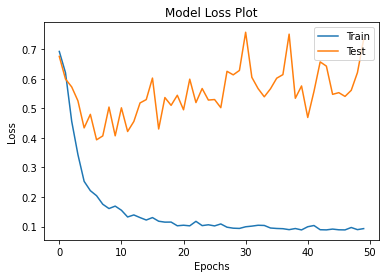

In [ ]:
import matplotlib.pyplot as plt                             ###plot loss on train and val data
plt.plot(attention_history.history['loss'])
plt.plot(attention_history.history['val_loss'])
plt.title('Model Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'],loc = 'upper right')
plt.show()

In [ ]:
att_model.save('attention_model.hdf5')

In [ ]:
att_model.load_weights('attention_model.hdf5')

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42069)
preds = []
fold = 0
aucs = 0
for train_idx, val_idx in kf.split(X_train):
    x_train_f = X_train[train_idx]
    y_train_f = Y_train[train_idx]
    x_val_f = X_train[val_idx]
    y_val_f = Y_train[val_idx]
    att_model.fit(x_train_f, y_train_f,
              batch_size=256,
              epochs=10,
              verbose = 0,
              validation_data=(x_val_f, y_val_f))
    # Get accuracy of model on validation data. It's not AUC but it's something at least!
    preds_val = att_model.predict([x_val_f], batch_size=512)
    preds.append(att_model.predict(X_test))
    fold+=1
    fpr, tpr, thresholds = roc_curve(y_val_f, preds_val, pos_label=1)
    aucs += auc(fpr,tpr)
    print('Fold {}, AUC = {}'.format(fold,auc(fpr, tpr)))
print("Cross Validation AUC = {}".format(aucs/10))

Fold 1, AUC = 0.9937559185606062
Fold 2, AUC = 0.9923058712121212
Fold 3, AUC = 0.9965333333333333
Fold 4, AUC = 0.9945597241215292
Fold 5, AUC = 0.9925870348139254
Fold 6, AUC = 0.9971522781774581
Fold 7, AUC = 0.9936098384374246
Fold 8, AUC = 0.9991947029348605
Fold 9, AUC = 0.9941249226963513
Fold 10, AUC = 0.9933166248955723
Cross Validation AUC = 0.9947140249183182


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
Y_pred = att_model.predict(X_test)
Y_pred = (Y_pred >0.5)

In [ ]:
confusion = confusion_matrix(Y_test,Y_pred)        ###Model evaluation
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
F1 = f1_score(Y_test,Y_pred)
specificity = (confusion[0][0]/(confusion[0][0]+confusion[0][1]))
print('confusion matrix {}'.format(confusion))
print('precision is {}'.format(precision))
print('recall is  {}'.format(recall))
print('F1 score {}'.format(F1))
print('specificity is {}'.format(specificity))

confusion matrix [[303  39]
 [ 47 260]]
precision is 0.8695652173913043
recall is  0.8469055374592834
F1 score 0.8580858085808581
specificity is 0.8859649122807017


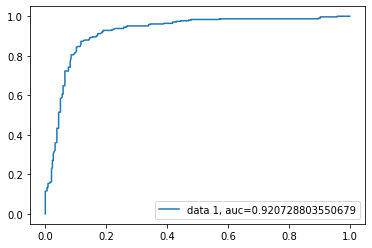

In [ ]:
Y_pred_proba = att_model.predict(X_test)
fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
auc = roc_auc_score(Y_test, Y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Attention MODEL: Case 2 - Using Pretrained embedding

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
embeddings = dict()                                 ##read glove vector file
example1 = "/content/drive/MyDrive/glove.6B.100d (1).txt"
f = open(example1, "r")
for line in f:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:],dtype='float32')
    embeddings[word]=vectors
f.close()

In [ ]:
embedding_matrix = np.zeros((vocab_len, 100))      ###create a matrix consist of words and its vectors
for word, i in train_tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
seq_input = keras.Input(shape=(100,))
e = Embedding(vocab_len, 100, input_length= 100,weights = [embedding_matrix], trainable= False)(seq_input)
conv1 = Conv1D(filters=256,kernel_size=5,activation='relu',strides= 1, kernel_initializer='he_uniform')(e)
pool = MaxPooling1D(pool_size=4)(conv1)
dropout= Dropout(0.5)(pool)
lstm1 = Bidirectional(LSTM(64, return_sequences=True))(dropout)
att=attention()(lstm1)
dense1 = Dense(units = 128, activation='relu', kernel_initializer='he_uniform')(att)
output= Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform')(dense1)
att_model1=keras.Model(seq_input,output)


In [ ]:
att_model1.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
attention_history=att_model1.fit(X_train, Y_train, epochs = 50, batch_size = 32, verbose = 1, validation_split = 0.1)

Epoch 1/50
73/73 [==============================] - 6s 20ms/step - loss: 0.6869 - accuracy: 0.5358 - val_loss: 0.6345 - val_accuracy: 0.6269
Epoch 2/50
73/73 [==============================] - 1s 7ms/step - loss: 0.6338 - accuracy: 0.6489 - val_loss: 0.6142 - val_accuracy: 0.6769
Epoch 3/50
73/73 [==============================] - 1s 7ms/step - loss: 0.5345 - accuracy: 0.7316 - val_loss: 0.5426 - val_accuracy: 0.7192
Epoch 4/50
73/73 [==============================] - 1s 7ms/step - loss: 0.4605 - accuracy: 0.7751 - val_loss: 0.4955 - val_accuracy: 0.7731
Epoch 5/50
73/73 [==============================] - 1s 7ms/step - loss: 0.4170 - accuracy: 0.8197 - val_loss: 0.5370 - val_accuracy: 0.7308
Epoch 6/50
73/73 [==============================] - 1s 7ms/step - loss: 0.3934 - accuracy: 0.8309 - val_loss: 0.4629 - val_accuracy: 0.8154
Epoch 7/50
73/73 [==============================] - 1s 7ms/step - loss: 0.3258 - accuracy: 0.8577 - val_loss: 0.4430 - val_accuracy: 0.8038
Epoch 8/50
73/73 [=

In [ ]:
score = att_model1.evaluate(X_test,Y_test,verbose = 1)
score[1]

21/21 [==============================] - 0s 4ms/step - loss: 0.5727 - accuracy: 0.8552


0.8551617860794067

In [ ]:
Y_pred = att_model1.predict(X_test)
Y_pred = (Y_pred >0.5)

In [ ]:
confusion = confusion_matrix(Y_test,Y_pred)        ###Model evaluation
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
F1 = f1_score(Y_test,Y_pred)
specificity = (confusion[0][0]/(confusion[0][0]+confusion[0][1]))
print('confusion matrix {}'.format(confusion))
print('precision is {}'.format(precision))
print('recall is  {}'.format(recall))
print('F1 score {}'.format(F1))
print('specificity is {}'.format(specificity))

confusion matrix [[300  42]
 [ 52 255]]
precision is 0.8585858585858586
recall is  0.8306188925081434
F1 score 0.8443708609271524
specificity is 0.8771929824561403


In [ ]:
X_train

array([[  1,  73, 167, ...,   0,   0,   0],
       [  9, 138,   7, ...,   0,   0,   0],
       [  3,  40,  27, ...,   0,   0,   0],
       ...,
       [  6,   0,   0, ...,   0,   0,   0],
       [  1,   2,  81, ...,   0,   0,   0],
       [124,  15,   0, ...,   0,   0,   0]], dtype=int32)

In [ ]:
X_train.shape

(2594, 100)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
kf = KFold(n_splits=10, shuffle=True, random_state=42069)
preds = []
fold = 0
aucs = 0
for train_idx, val_idx in kf.split(X_train):
    x_train_f = X_train[train_idx]
    y_train_f = Y_train[train_idx]
    x_val_f = X_train[val_idx]
    y_val_f = Y_train[val_idx]
    att_model1.fit(x_train_f, y_train_f,
              batch_size=256,
              epochs=10,
              verbose = 0,
              validation_data=(x_val_f, y_val_f))
    # Get accuracy of model on validation data. It's not AUC but it's something at least!
    preds_val = att_model1.predict([x_val_f], batch_size=256)
    preds.append(att_model1.predict(X_test))
    fold = fold + 1
    fpr, tpr, thresholds = roc_curve(y_val_f, preds_val, pos_label=0)
    aucs = aucs + auc(fpr, tpr)
    fpr, tpr, thresholds = roc_curve(y_val_f, preds_val, pos_label=1)
    aucs += auc(fpr,tpr)
    print('Fold {}, AUC = {}'.format(fold,auc(fpr, tpr)))
print("Cross Validation AUC = {}".format(aucs/10))    

Fold 1, AUC = 0.9923946496212122
Fold 2, AUC = 0.9921283143939394
Fold 3, AUC = 0.9962962962962963
Fold 4, AUC = 0.9938462453177953
Fold 5, AUC = 0.9922869147659062
Fold 6, AUC = 0.9967326139088729
Fold 7, AUC = 0.9929467084639498
Fold 8, AUC = 0.9990753996659508
Fold 9, AUC = 0.9939393939393939
Fold 10, AUC = 0.9940327007996181
Cross Validation AUC = 1.0


# Hyperparameter Tuning

In [ ]:
def model_attention1_create(optimizer = 'Adam',
                 dropout_rate = 0.2, nb_filters = 256, kernel_size = 5,pool_size=2,units = 128,neurons = 20):
    
    seq_input = keras.Input(shape=(100,))
    e = Embedding(vocab_len, 100, input_length= 100,weights = [embedding_matrix], trainable= False)(seq_input)
    conv1 = Conv1D(nb_filters,kernel_size,activation='relu',strides= 1, kernel_initializer='he_uniform')(e)
    pool = MaxPooling1D(pool_size)(conv1)
    dropout= Dropout(0.5)(pool)
    lstm1 = Bidirectional(LSTM(10, return_sequences=True))(dropout)
    att=attention()(lstm1)
    dense1 = Dense(units = neurons, activation='relu', kernel_initializer='he_uniform')(att)
    output= Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform')(dense1)
    model=keras.Model(seq_input,output) 
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [ ]:
param_grid = {
    'nb_filters': [128,256],
    'kernel_size':[3,5],
    'pool_size':[2,4]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention1_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] kernel_size=3, nb_filters=128, pool_size=2 ......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
65/65 - 4s - loss: 0.6868 - accuracy: 0.5624
Epoch 2/10
65/65 - 0s - loss: 0.6534 - accuracy: 0.6251
Epoch 3/10
65/65 - 0s - loss: 0.6239 - accuracy: 0.6627
Epoch 4/10
65/65 - 0s - loss: 0.5969 - accuracy: 0.6901
Epoch 5/10
65/65 - 0s - loss: 0.5719 - accuracy: 0.7036
Epoch 6/10
65/65 - 0s - loss: 0.5389 - accuracy: 0.7475
Epoch 7/10
65/65 - 0s - loss: 0.4985 - accuracy: 0.7730
Epoch 8/10
65/65 - 0s - loss: 0.4983 - accuracy: 0.7735
Epoch 9/10
65/65 - 0s - loss: 0.4681 - accuracy: 0.8014
Epoch 10/10
65/65 - 0s - loss: 0.4481 - accuracy: 0.8039
17/17 - 1s - loss: 0.5635 - accuracy: 0.7399
[CV] ....... kernel_size=3, nb_filters=128, pool_size=2, total=   9.4s
[CV] kernel_size=3, nb_filters=128, pool_size=2 ......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s


Epoch 1/10
65/65 - 4s - loss: 0.6868 - accuracy: 0.5465
Epoch 2/10
65/65 - 0s - loss: 0.6507 - accuracy: 0.6308
Epoch 3/10
65/65 - 0s - loss: 0.6201 - accuracy: 0.6549
Epoch 4/10
65/65 - 0s - loss: 0.5937 - accuracy: 0.6930
Epoch 5/10
65/65 - 0s - loss: 0.5642 - accuracy: 0.7181
Epoch 6/10
65/65 - 0s - loss: 0.5383 - accuracy: 0.7373
Epoch 7/10
65/65 - 0s - loss: 0.5232 - accuracy: 0.7537
Epoch 8/10
65/65 - 0s - loss: 0.5017 - accuracy: 0.7706
Epoch 9/10
65/65 - 0s - loss: 0.4882 - accuracy: 0.7716
Epoch 10/10
65/65 - 0s - loss: 0.4563 - accuracy: 0.7923
17/17 - 1s - loss: 0.5272 - accuracy: 0.7380
[CV] ....... kernel_size=3, nb_filters=128, pool_size=2, total=   9.0s
[CV] kernel_size=3, nb_filters=128, pool_size=2 ......................
Epoch 1/10
65/65 - 4s - loss: 0.6897 - accuracy: 0.5417
Epoch 2/10
65/65 - 0s - loss: 0.6611 - accuracy: 0.6333
Epoch 3/10
65/65 - 0s - loss: 0.6258 - accuracy: 0.6530
Epoch 4/10
65/65 - 0s - loss: 0.5961 - accuracy: 0.6829
Epoch 5/10
65/65 - 0s - loss

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  6.0min finished


Epoch 1/10
82/82 - 4s - loss: 0.6878 - accuracy: 0.5544
Epoch 2/10
82/82 - 0s - loss: 0.6407 - accuracy: 0.6315
Epoch 3/10
82/82 - 0s - loss: 0.5874 - accuracy: 0.6912
Epoch 4/10
82/82 - 1s - loss: 0.5305 - accuracy: 0.7436
Epoch 5/10
82/82 - 1s - loss: 0.4809 - accuracy: 0.7729
Epoch 6/10
82/82 - 0s - loss: 0.4608 - accuracy: 0.7864
Epoch 7/10
82/82 - 0s - loss: 0.3999 - accuracy: 0.8281
Epoch 8/10
82/82 - 0s - loss: 0.3761 - accuracy: 0.8234
Epoch 9/10
82/82 - 0s - loss: 0.3575 - accuracy: 0.8431
Epoch 10/10
82/82 - 0s - loss: 0.3420 - accuracy: 0.8497
Best accuracy:  0.7937442898750305
Best parameters:  {'kernel_size': 5, 'nb_filters': 128, 'pool_size': 4}


In [ ]:
param_grid = {
    'neurons':[10,20,64,128]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention1_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] neurons=10 ......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
65/65 - 3s - loss: 0.6857 - accuracy: 0.5624
Epoch 2/10
65/65 - 0s - loss: 0.6392 - accuracy: 0.6530
Epoch 3/10
65/65 - 0s - loss: 0.5843 - accuracy: 0.6983
Epoch 4/10
65/65 - 0s - loss: 0.5303 - accuracy: 0.7460
Epoch 5/10
65/65 - 0s - loss: 0.5075 - accuracy: 0.7740
Epoch 6/10
65/65 - 0s - loss: 0.4689 - accuracy: 0.7971
Epoch 7/10
65/65 - 0s - loss: 0.4407 - accuracy: 0.8130
Epoch 8/10
65/65 - 0s - loss: 0.4067 - accuracy: 0.8308
Epoch 9/10
65/65 - 0s - loss: 0.3789 - accuracy: 0.8482
Epoch 10/10
65/65 - 0s - loss: 0.3556 - accuracy: 0.8593
17/17 - 1s - loss: 0.5489 - accuracy: 0.7630
[CV] ....................................... neurons=10, total=   8.9s
[CV] neurons=10 ......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s


Epoch 1/10
65/65 - 4s - loss: 0.6813 - accuracy: 0.5701
Epoch 2/10
65/65 - 0s - loss: 0.6350 - accuracy: 0.6520
Epoch 3/10
65/65 - 0s - loss: 0.5854 - accuracy: 0.6935
Epoch 4/10
65/65 - 0s - loss: 0.5508 - accuracy: 0.7292
Epoch 5/10
65/65 - 0s - loss: 0.4946 - accuracy: 0.7778
Epoch 6/10
65/65 - 0s - loss: 0.4854 - accuracy: 0.7754
Epoch 7/10
65/65 - 0s - loss: 0.4385 - accuracy: 0.8048
Epoch 8/10
65/65 - 0s - loss: 0.4052 - accuracy: 0.8294
Epoch 9/10
65/65 - 0s - loss: 0.3685 - accuracy: 0.8463
Epoch 10/10
65/65 - 0s - loss: 0.3387 - accuracy: 0.8583
17/17 - 1s - loss: 0.5302 - accuracy: 0.7803
[CV] ....................................... neurons=10, total=   9.5s
[CV] neurons=10 ......................................................
Epoch 1/10
65/65 - 3s - loss: 0.6865 - accuracy: 0.5528
Epoch 2/10
65/65 - 0s - loss: 0.6503 - accuracy: 0.6366
Epoch 3/10
65/65 - 0s - loss: 0.6107 - accuracy: 0.6877
Epoch 4/10
65/65 - 0s - loss: 0.5718 - accuracy: 0.7176
Epoch 5/10
65/65 - 0s - loss

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.0min finished


Epoch 1/10
82/82 - 4s - loss: 0.6796 - accuracy: 0.5790
Epoch 2/10
82/82 - 1s - loss: 0.6184 - accuracy: 0.6681
Epoch 3/10
82/82 - 1s - loss: 0.5715 - accuracy: 0.7097
Epoch 4/10
82/82 - 1s - loss: 0.5321 - accuracy: 0.7413
Epoch 5/10
82/82 - 1s - loss: 0.4791 - accuracy: 0.7772
Epoch 6/10
82/82 - 1s - loss: 0.4712 - accuracy: 0.7803
Epoch 7/10
82/82 - 1s - loss: 0.4014 - accuracy: 0.8261
Epoch 8/10
82/82 - 1s - loss: 0.3662 - accuracy: 0.8400
Epoch 9/10
82/82 - 1s - loss: 0.3486 - accuracy: 0.8535
Epoch 10/10
82/82 - 1s - loss: 0.3269 - accuracy: 0.8643
Best accuracy:  0.7964425325393677
Best parameters:  {'neurons': 20}


In [ ]:
param_grid = {
    'dropout_rate':[0.1,0.2,0.3,0.4,0.5]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention1_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] dropout_rate=0.1 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
65/65 - 4s - loss: 0.6803 - accuracy: 0.5754
Epoch 2/10
65/65 - 0s - loss: 0.6294 - accuracy: 0.6525
Epoch 3/10
65/65 - 0s - loss: 0.5856 - accuracy: 0.6896
Epoch 4/10
65/65 - 0s - loss: 0.5113 - accuracy: 0.7639
Epoch 5/10
65/65 - 0s - loss: 0.4877 - accuracy: 0.7677
Epoch 6/10
65/65 - 0s - loss: 0.4329 - accuracy: 0.8101
Epoch 7/10
65/65 - 0s - loss: 0.3992 - accuracy: 0.8275
Epoch 8/10
65/65 - 0s - loss: 0.3778 - accuracy: 0.8419
Epoch 9/10
65/65 - 0s - loss: 0.3454 - accuracy: 0.8549
Epoch 10/10
65/65 - 0s - loss: 0.3172 - accuracy: 0.8742
17/17 - 1s - loss: 0.4675 - accuracy: 0.8054
[CV] ................................. dropout_rate=0.1, total=   8.9s
[CV] dropout_rate=0.1 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s


Epoch 1/10
65/65 - 3s - loss: 0.6816 - accuracy: 0.5677
Epoch 2/10
65/65 - 0s - loss: 0.6329 - accuracy: 0.6559
Epoch 3/10
65/65 - 0s - loss: 0.5727 - accuracy: 0.7065
Epoch 4/10
65/65 - 0s - loss: 0.5391 - accuracy: 0.7393
Epoch 5/10
65/65 - 0s - loss: 0.5089 - accuracy: 0.7619
Epoch 6/10
65/65 - 0s - loss: 0.4525 - accuracy: 0.8039
Epoch 7/10
65/65 - 0s - loss: 0.4243 - accuracy: 0.8145
Epoch 8/10
65/65 - 0s - loss: 0.3775 - accuracy: 0.8458
Epoch 9/10
65/65 - 0s - loss: 0.3528 - accuracy: 0.8477
Epoch 10/10
65/65 - 0s - loss: 0.3207 - accuracy: 0.8766
17/17 - 2s - loss: 0.4902 - accuracy: 0.8150
[CV] ................................. dropout_rate=0.1, total=   9.4s
[CV] dropout_rate=0.1 ................................................
Epoch 1/10
65/65 - 4s - loss: 0.6841 - accuracy: 0.5605
Epoch 2/10
65/65 - 0s - loss: 0.6417 - accuracy: 0.6410
Epoch 3/10
65/65 - 0s - loss: 0.5877 - accuracy: 0.6954
Epoch 4/10
65/65 - 0s - loss: 0.5452 - accuracy: 0.7475
Epoch 5/10
65/65 - 0s - loss

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.8min finished


Epoch 1/10
82/82 - 4s - loss: 0.6791 - accuracy: 0.5856
Epoch 2/10
82/82 - 1s - loss: 0.6324 - accuracy: 0.6527
Epoch 3/10
82/82 - 1s - loss: 0.5877 - accuracy: 0.7035
Epoch 4/10
82/82 - 1s - loss: 0.5445 - accuracy: 0.7340
Epoch 5/10
82/82 - 1s - loss: 0.4938 - accuracy: 0.7745
Epoch 6/10
82/82 - 1s - loss: 0.4530 - accuracy: 0.8034
Epoch 7/10
82/82 - 1s - loss: 0.4201 - accuracy: 0.8207
Epoch 8/10
82/82 - 1s - loss: 0.3846 - accuracy: 0.8400
Epoch 9/10
82/82 - 1s - loss: 0.3453 - accuracy: 0.8551
Epoch 10/10
82/82 - 1s - loss: 0.3399 - accuracy: 0.8547
Best accuracy:  0.7852619767189026
Best parameters:  {'dropout_rate': 0.1}


In [ ]:
param_grid = {
    'units': [10,20,64,128]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_attention1_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 10)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] units=10 ........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
65/65 - 4s - loss: 0.6821 - accuracy: 0.5610
Epoch 2/10
65/65 - 0s - loss: 0.6486 - accuracy: 0.6333
Epoch 3/10
65/65 - 0s - loss: 0.6143 - accuracy: 0.6713
Epoch 4/10
65/65 - 0s - loss: 0.5603 - accuracy: 0.7210
Epoch 5/10
65/65 - 0s - loss: 0.5313 - accuracy: 0.7455
Epoch 6/10
65/65 - 0s - loss: 0.4790 - accuracy: 0.7798
Epoch 7/10
65/65 - 0s - loss: 0.4489 - accuracy: 0.8029
Epoch 8/10
65/65 - 0s - loss: 0.4004 - accuracy: 0.8376
Epoch 9/10
65/65 - 0s - loss: 0.3974 - accuracy: 0.8299
Epoch 10/10
65/65 - 0s - loss: 0.3672 - accuracy: 0.8549
17/17 - 1s - loss: 0.5420 - accuracy: 0.7823
[CV] ......................................... units=10, total=   9.5s
[CV] units=10 ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s remaining:    0.0s


Epoch 1/10
65/65 - 3s - loss: 0.6875 - accuracy: 0.5561
Epoch 2/10
65/65 - 0s - loss: 0.6524 - accuracy: 0.6260
Epoch 3/10
65/65 - 0s - loss: 0.5968 - accuracy: 0.6819
Epoch 4/10
65/65 - 0s - loss: 0.5484 - accuracy: 0.7243
Epoch 5/10
65/65 - 0s - loss: 0.5177 - accuracy: 0.7523
Epoch 6/10
65/65 - 0s - loss: 0.4774 - accuracy: 0.7855
Epoch 7/10
65/65 - 0s - loss: 0.4454 - accuracy: 0.8029
Epoch 8/10
65/65 - 0s - loss: 0.4177 - accuracy: 0.8236
Epoch 9/10
65/65 - 0s - loss: 0.3971 - accuracy: 0.8236
Epoch 10/10
65/65 - 0s - loss: 0.3709 - accuracy: 0.8439
17/17 - 1s - loss: 0.5564 - accuracy: 0.7553
[CV] ......................................... units=10, total=   8.8s
[CV] units=10 ........................................................
Epoch 1/10
65/65 - 4s - loss: 0.6885 - accuracy: 0.5436
Epoch 2/10
65/65 - 0s - loss: 0.6379 - accuracy: 0.6607
Epoch 3/10
65/65 - 0s - loss: 0.5947 - accuracy: 0.6940
Epoch 4/10
65/65 - 0s - loss: 0.5390 - accuracy: 0.7465
Epoch 5/10
65/65 - 0s - loss

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.1min finished


Epoch 1/10
82/82 - 4s - loss: 0.6788 - accuracy: 0.5744
Epoch 2/10
82/82 - 1s - loss: 0.6237 - accuracy: 0.6619
Epoch 3/10
82/82 - 1s - loss: 0.5555 - accuracy: 0.7209
Epoch 4/10
82/82 - 1s - loss: 0.5168 - accuracy: 0.7533
Epoch 5/10
82/82 - 1s - loss: 0.4739 - accuracy: 0.7791
Epoch 6/10
82/82 - 1s - loss: 0.4375 - accuracy: 0.8061
Epoch 7/10
82/82 - 1s - loss: 0.4153 - accuracy: 0.8157
Epoch 8/10
82/82 - 1s - loss: 0.3625 - accuracy: 0.8470
Epoch 9/10
82/82 - 1s - loss: 0.3361 - accuracy: 0.8635
Epoch 10/10
82/82 - 1s - loss: 0.3144 - accuracy: 0.8755
Best accuracy:  0.7814061999320984
Best parameters:  {'units': 128}


# MODEL with Optimised Parameters

In [ ]:
seq_input = keras.Input(shape=(100,))
e = Embedding(vocab_len, 100, input_length= 100,weights = [embedding_matrix], trainable= False)(seq_input)
conv1 = Conv1D(filters=256,kernel_size=5,activation='relu',strides= 1, kernel_initializer='he_uniform')(e)
pool = MaxPooling1D(pool_size=4)(conv1)
dropout= Dropout(0.5)(pool)
lstm1 = Bidirectional(LSTM(20, return_sequences=True))(dropout)
att=attention()(lstm1)
dense1 = Dense(units = 128, activation='relu', kernel_initializer='he_uniform')(att)
output= Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform')(dense1)
att_model2=keras.Model(seq_input,output)

In [ ]:
att_model2.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
attention_history=att_model2.fit(X_train, Y_train, epochs = 50, batch_size = 32, verbose = 1, validation_split = 0.1)

Epoch 1/50
73/73 [==============================] - 5s 19ms/step - loss: 0.6924 - accuracy: 0.4982 - val_loss: 0.6527 - val_accuracy: 0.6385
Epoch 2/50
73/73 [==============================] - 1s 7ms/step - loss: 0.6408 - accuracy: 0.6366 - val_loss: 0.6212 - val_accuracy: 0.6731
Epoch 3/50
73/73 [==============================] - 1s 7ms/step - loss: 0.5896 - accuracy: 0.6806 - val_loss: 0.6094 - val_accuracy: 0.6885
Epoch 4/50
73/73 [==============================] - 1s 7ms/step - loss: 0.5049 - accuracy: 0.7583 - val_loss: 0.5355 - val_accuracy: 0.7577
Epoch 5/50
73/73 [==============================] - 1s 7ms/step - loss: 0.4462 - accuracy: 0.7914 - val_loss: 0.5224 - val_accuracy: 0.7462
Epoch 6/50
73/73 [==============================] - 1s 7ms/step - loss: 0.3916 - accuracy: 0.8202 - val_loss: 0.5471 - val_accuracy: 0.7500
Epoch 7/50
73/73 [==============================] - 1s 8ms/step - loss: 0.3636 - accuracy: 0.8413 - val_loss: 0.4995 - val_accuracy: 0.8000
Epoch 8/50
73/73 [=

In [ ]:
score = att_model2.evaluate(X_test,Y_test,verbose = 1)
score[1]

21/21 [==============================] - 0s 3ms/step - loss: 0.4840 - accuracy: 0.8752


0.8751925826072693

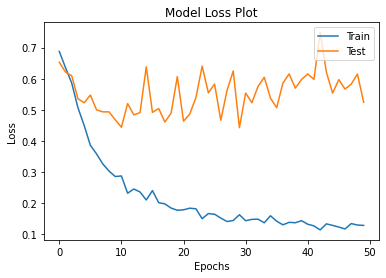

In [ ]:
import matplotlib.pyplot as plt                             ###plot loss on train and val data
plt.plot(attention_history.history['loss'])
plt.plot(attention_history.history['val_loss'])
plt.title('Model Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'],loc = 'upper right')
plt.show()

In [ ]:
att_model2.save('attention_pretrained.hdf5')

In [ ]:
att_model2.load_weights('attention_pretrained.hdf5')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
Y_pred = att_model2.predict(X_test)
Y_pred = (Y_pred >0.5)

In [ ]:
confusion = confusion_matrix(Y_test,Y_pred)        ###Model evaluation
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
F1 = f1_score(Y_test,Y_pred)
specificity = (confusion[0][0]/(confusion[0][0]+confusion[0][1]))
print('confusion matrix {}'.format(confusion))
print('precision is {}'.format(precision))
print('recall is  {}'.format(recall))
print('F1 score {}'.format(F1))
print('specificity is {}'.format(specificity))

confusion matrix [[306  36]
 [ 45 262]]
precision is 0.8791946308724832
recall is  0.8534201954397395
F1 score 0.8661157024793389
specificity is 0.8947368421052632


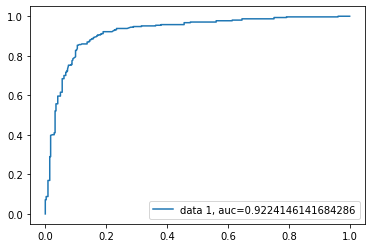

In [ ]:
Y_pred_proba = att_model2.predict(X_test)
fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
auc = roc_auc_score(Y_test, Y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
kf = KFold(n_splits=10, shuffle=True, random_state=42069)
preds = []
fold = 0
aucs = 0
for train_idx, val_idx in kf.split(X_train):
    x_train_f = X_train[train_idx]
    y_train_f = Y_train[train_idx]
    x_val_f = X_train[val_idx]
    y_val_f = Y_train[val_idx]
    att_model2.fit(x_train_f, y_train_f,
              batch_size=256,
              epochs=10,
              verbose = 0,
              validation_data=(x_val_f, y_val_f))
    # Get accuracy of model on validation data. It's not AUC but it's something at least!
    preds_val = att_model2.predict([x_val_f], batch_size=256)
    preds.append(att_model2.predict(X_test))
    fold = fold + 1
    fpr, tpr, thresholds = roc_curve(y_val_f, preds_val, pos_label=0)
    aucs = aucs + auc(fpr, tpr)
    fpr, tpr, thresholds = roc_curve(y_val_f, preds_val, pos_label=1)
    aucs += auc(fpr,tpr)
    print('Fold {}, AUC = {}'.format(fold,auc(fpr, tpr)))
print("Cross Validation AUC = {}".format(aucs/10))    

Fold 1, AUC = 0.9934008049242424
Fold 2, AUC = 0.9917732007575757
Fold 3, AUC = 0.9950518518518519
Fold 4, AUC = 0.9910517866698376
Fold 5, AUC = 0.9929471788715486
Fold 6, AUC = 0.9968525179856115
Fold 7, AUC = 0.9938509766095973
Fold 8, AUC = 0.9991350513004056
Fold 9, AUC = 0.9943104514533087
Fold 10, AUC = 0.9935553168635876
Cross Validation AUC = 1.0
